# Does the newer version of Trinity (v2.8.4) make better transcriptome assemblies (for killifish) than the old (v2.2.0)?

Report for supplement to XSEDE allocation BIO160028

Lisa K. Johnson

December 8, 2018

In [1]:
%matplotlib inline
%pylab inline
import pandas as pd
import pylab as pl
import matplotlib.pyplot as plt
import palettable as pal
import matplotlib as mpl
import seaborn as sns
import numpy
import pyupset as pyu
# mpl.rcParams['font.sans-serif']='Arial'
# mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['pdf.fonttype'] = 42

Populating the interactive namespace from numpy and matplotlib


In [3]:
all_metrics = pd.read_csv("../evaluation/Fundulus_transcriptome_assembly_evaluation_matrix.csv")
old_busco = pd.read_csv("../evaluation/old_busco_scores.csv")

In [6]:
busco_new = all_metrics[['species','Complete_euk_perc','Complete_metazoa_perc']]
busco_old = old_busco[['species','Complete_euk_proportion','Complete_metazoa_proportion']]

In [7]:
# rename col names
busco_old.columns = ['species','Complete_euk_perc','Complete_metazoa_perc']

In [8]:
busco_new

,species,Complete_euk_perc,Complete_metazoa_perc
0,A_xenica,99.669967,98.875256
1,F_catanatus,99.339934,98.773006
2,F_chrysotus,98.679868,98.773006
3,F_diaphanus,99.339934,98.773006
4,F_grandis,98.349835,98.977505
5,F_heteroclitusMDPL,99.009901,98.773006
6,F_heteroclitusMDPP,99.339934,98.875256
7,F_notatus,99.339934,99.079755
8,F_notti,98.679868,97.648262
9,F_olivaceous,99.669967,98.261759


In [36]:
metrics_new = all_metrics[['species', 'n_seqs_new','n_with_orf_new','largest_new','mean_orf_percent_new','n_bases_new','unique_kmers_new']]
metrics_old = all_metrics[['species','n_seqs_old','n_with_orf_old','largest_old','mean_orf_percent_old','n_bases_old','unique_kmers_old']]

In [37]:
metrics_new.columns = ['species','contigs','n_with_orf','largest','mean_orf_perc','n_bases','unique_kmers']
metrics_old.columns = ['species','contigs','n_with_orf','largest','mean_orf_perc','n_bases','unique_kmers']

In [11]:
metrics_new

,species,contigs,n_with_orf,largest,mean_orf_perc,n_bases,unique_kmers
0,A_xenica,301664,79919,21149,41.86545,381329529,163706957
1,F_catanatus,325956,78828,32158,41.45704,392758373,198347597
2,F_chrysotus,328866,82126,27960,39.82807,417877726,192813036
3,F_diaphanus,320734,65787,22815,44.20562,325735698,157163913
4,F_grandis,676974,101233,64901,44.08229,564126240,301047217
5,F_heteroclitusMDPL,489882,93088,30723,42.73127,487813606,220122131
6,F_heteroclitusMDPP,552205,87407,30054,42.95918,488797077,233149064
7,F_notatus,343128,83586,28093,39.58724,434881519,182354234
8,F_notti,131628,39296,27001,47.95473,159730981,74597887
9,F_olivaceous,296801,70836,33490,41.52890,358020368,146401065


In [12]:
combined_df = pd.merge(metrics_new, metrics_old, left_index=True, right_index=True)
newdf=pd.DataFrame(index=combined_df.index)

In [13]:
column = 'unique_kmers'
newdf['new']=combined_df[column+'_x']
newdf['old']=combined_df[column+'_y']

In [115]:
def scatter_diff(df1, df2, column, fig, ax, df1name = 'df1', df2name = 'df2', 
                 color1='green', color2='blue', ymin=0, ymax=1, ypos=.95):
    # plot scatter differences between two dfs with the same columns
    # create new df for data comparison
    
    combined_df = pd.merge(df1, df2, left_index=True, right_index=True)
    newdf=pd.DataFrame(index=combined_df.index)
    newdf[df1name]=combined_df[column+'_x']
    newdf[df2name]=combined_df[column+'_y']

    # plot with different colors if df1 > or < then df2
    
    newdf.loc[newdf[df1name] > newdf[df2name], [df1name, df2name]].T.plot(ax=ax, legend = False, 
                                                                          color = color1, alpha = 0.5, lw=2)
    newdf.loc[newdf[df1name] <= newdf[df2name], [df1name, df2name]].T.plot(ax=ax, legend = False, 
                                                                           color = color2, alpha = 0.2, lw=2)
    # prints numbers higher in DIB or NCGR assemblies
    #ax.text(-.1, ypos, str(len(newdf.loc[newdf[df1name] > newdf[df2name]])), 
            #color= color1, fontsize='x-large', fontweight='heavy')
    #ax.text(.95, ypos, str(len(newdf.loc[newdf[df1name] <= newdf[df2name]])), 
            #color= color2, fontsize='x-large', fontweight='heavy')

    # aesthetics 
    ax.set_xlim(-.15, 1.3)
    ax.set_ylim(ymin, ymax)
    ax.set_xticks([0,1])
    ax.set_xticklabels([df1name, df2name], fontsize='large', fontweight='bold', fontname='Arial')
    ax.set_axis_bgcolor('white')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(labelsize='x-large')
    ax.tick_params(axis='x', which='both', top='off', bottom='off')
    ax.tick_params(axis='y', which='both', right='off')
    for tick in ax.get_yticklabels():
        tick.set_fontname("Arial")
    return newdf, fig, ax
    

def violin_split(df, col1, col2, fig, ax, color2='green', color1='blue', ymin=0, ymax=1, letter2='B'):
    #create split violine plots
    v1 = ax.violinplot(df[col1],
                   showmeans=False, showextrema=False, showmedians=False)
    for b in v1['bodies']:
        m = np.mean(b.get_paths()[0].vertices[:, 0])
        b.get_paths()[0].vertices[:, 0] = np.clip(b.get_paths()[0].vertices[:, 0], -np.inf, m)
        b.set_color(color2)
        b.set_alpha(0.5)
    v2 = ax.violinplot(df[col2],
                   showmeans=False, showextrema=False, showmedians=False)
    for b in v2['bodies']:
        m = np.mean(b.get_paths()[0].vertices[:, 0])
        b.get_paths()[0].vertices[:, 0] = np.clip(b.get_paths()[0].vertices[:, 0], m, np.inf)
        b.set_color(color1)
        b.set_alpha(0.5)
    
    [x1,x2]=ax.get_xlim()
    ax.plot([0,1], [df[col1].mean()]*2,'--', color='black')
    ax.plot([1,2], [df[col2].mean()]*2, '--', color='black')
    calc_value_ncgr = round(df[col1].mean(),2)
    calc_value_dib = round(df[col2].mean(),2)
    if calc_value_ncgr >= 1000:
        calc_value_ncgr = str(int(calc_value_ncgr/1000)) + "K"
    if calc_value_dib >= 1000:
        calc_value_dib = str(int(calc_value_dib/1000)) + "K"
    elif calc_value_ncgr >= 1000000:
        calc_value_ncgr = str(int(calc_value_ncgr/1000000)) + "M"
    elif calc_value_dib >= 1000000:
        calc_value_dib = str(int(calc_value_dib/1000000)) + "M"
    calc_value_ncgr = str(calc_value_ncgr)
    calc_value_dib = str(calc_value_dib)
    ax.text(0.5+x1/2, df[col1].mean(), calc_value_ncgr, fontsize='x-large', fontweight='bold',
            multialignment='center', fontname='Arial')
    ax.text(0.5+x2/2, df[col2].mean(), calc_value_dib, fontsize='x-large', fontweight='bold',
            multialignment='center', fontname='Arial')
    ax.set_xlim(x1,x2)
    ax.set_xticks([x1,x2])
    ax.set_xticklabels(['new', 'old'], fontsize='large', fontweight='bold', fontname='Arial')
    ax.set_ylim([ymin, ymax])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(axis= 'both',labelsize='x-large')
    #ax.set_axis_bgcolor('white')
    ax.set_yticklabels('')
    ax.tick_params(axis='x', which='both', top='off', bottom='off')
    #ax.tick_params(axis='x', which='both', top='off')
    ax.tick_params(axis='y', which='both', right='off')

def create_plots(df1, df2, column, col_title, df1name = 'new', df2name = 'old', ymax = 1, ymin = 0, ypos = 0.90):
    fig, axs = plt.subplots(1,2)
    fig.set_size_inches(6,6)
    outdf, fig, ax = scatter_diff(df1, df2, column = column,
                                  fig = fig, ax = axs[0],
                                  df1name = df1name, 
                                  df2name = df2name, 
                                  ymax = ymax, 
                                  ymin = ymin, 
                                  ypos = ypos)
    violin_split(outdf, df1name, df2name, fig, axs[1], ymin = ymin, ymax = ymax)
    fig.suptitle(col_title, fontsize = 'x-large', fontweight = 'bold', fontname='Arial')
    
    return outdf, fig, ax

/Users/johnsolk/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:28: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


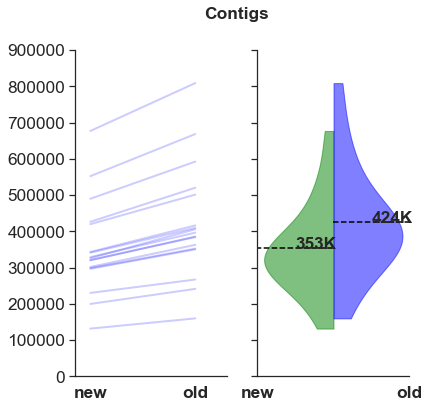

In [111]:
score,fig, ax = create_plots(metrics_new,metrics_old, 'contigs', 'Contigs',ymax=900000)
savefig('contigs.png',bbox_inches="tight")

/Users/johnsolk/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:28: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


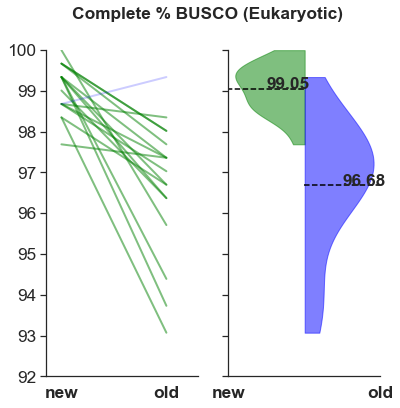

In [116]:
score,fig, ax = create_plots(busco_new,busco_old, 'Complete_euk_perc', 'Complete % BUSCO (Eukaryotic)',ymax=100,ymin=92,ypos = 90)
savefig('busco_euk.png',bbox_inches="tight")

/Users/johnsolk/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:28: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


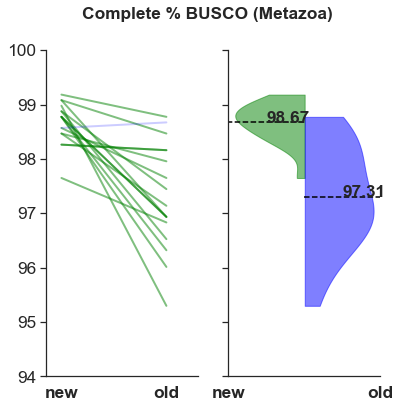

In [117]:
score,fig, ax = create_plots(busco_new,busco_old, 'Complete_metazoa_perc', 'Complete % BUSCO (Metazoa)',ymax=100,ymin=94,ypos = 90)
savefig('busco_metazoa.png',bbox_inches="tight")

/Users/johnsolk/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:28: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


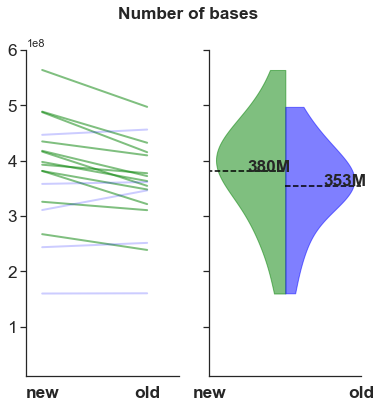

In [107]:
score,fig, ax = create_plots(metrics_new,metrics_old, 'n_bases', 'Number of bases',ymin=10000000,ymax=600000000)
savefig('bases.png',bbox_inches="tight")

/Users/johnsolk/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:28: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


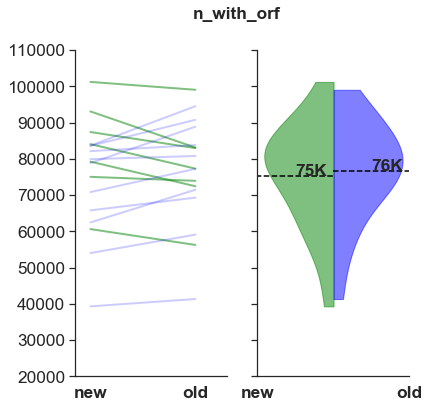

In [109]:
score,fig, ax = create_plots(metrics_new,metrics_old, 'n_with_orf', 'n_with_orf',ymax=110000,ymin=20000)
savefig('n_orf.png',bbox_inches="tight")

/Users/johnsolk/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:28: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


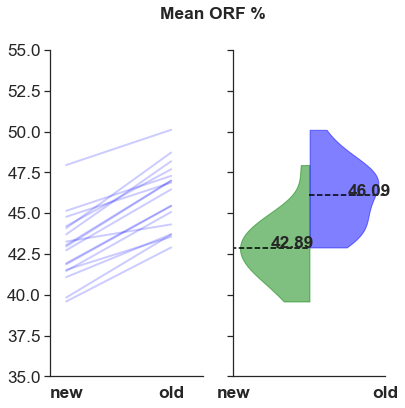

In [112]:
score,fig, ax = create_plots(metrics_new,metrics_old, 'mean_orf_perc', 'Mean ORF %',ymax=55,ymin=35)
savefig('orf_perc.png',bbox_inches="tight")

/Users/johnsolk/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:28: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


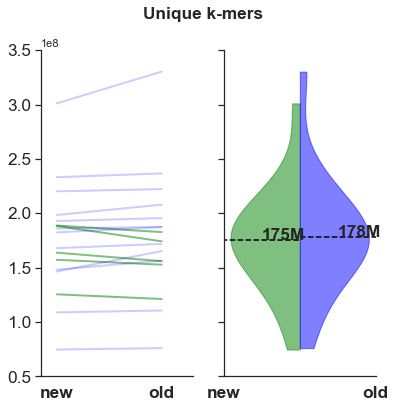

In [105]:
score,fig, ax = create_plots(metrics_new,metrics_old, 'unique_kmers', 'Unique k-mers',ymax=350000000,ymin=50000000)
savefig('kmers.png',bbox_inches="tight")

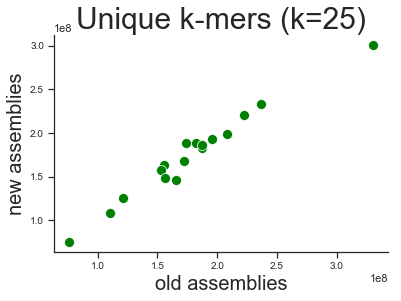

In [113]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")
sns.set_style("ticks")
b = sns.scatterplot(x="old", y="new", s=100, color="green",data=newdf)
b.set_title('Unique k-mers (k=25)',fontsize=30)
b.set_xlabel("old assemblies",fontsize=20)
b.set_ylabel("new assemblies",fontsize=20)
b.tick_params(labelsize=10)
sns.despine();
savefig('kmers_scatter.png',bbox_inches="tight")